In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
from time import time

In [5]:
plt.rcParams["figure.figsize"] = (20,20)
np.set_printoptions(threshold=sys.maxsize)

In [71]:
def convolve(img,kernel):
    k_size=kernel.shape
    size=img.shape
    d=k_size[0]
    k=int(d/2)
    img1=np.zeros((size[0],size[1]))
    image_padded = np.pad(img, ((k,k), (k,k)), 'edge')
    for i in range(size[0]):
        for j in range(size[1]):
            temp=np.multiply(kernel,image_padded[i:i+d,j:j+d])
            img1[i,j]=temp.sum()
    
    img1=np.clip(img1,0,255)        
    return img1
    

In [72]:
def averaging_filter(img,k):
    kernel=np.ones((k,k))
    kernel=kernel/(k*k)
    output=convolve(img,kernel)
    return output

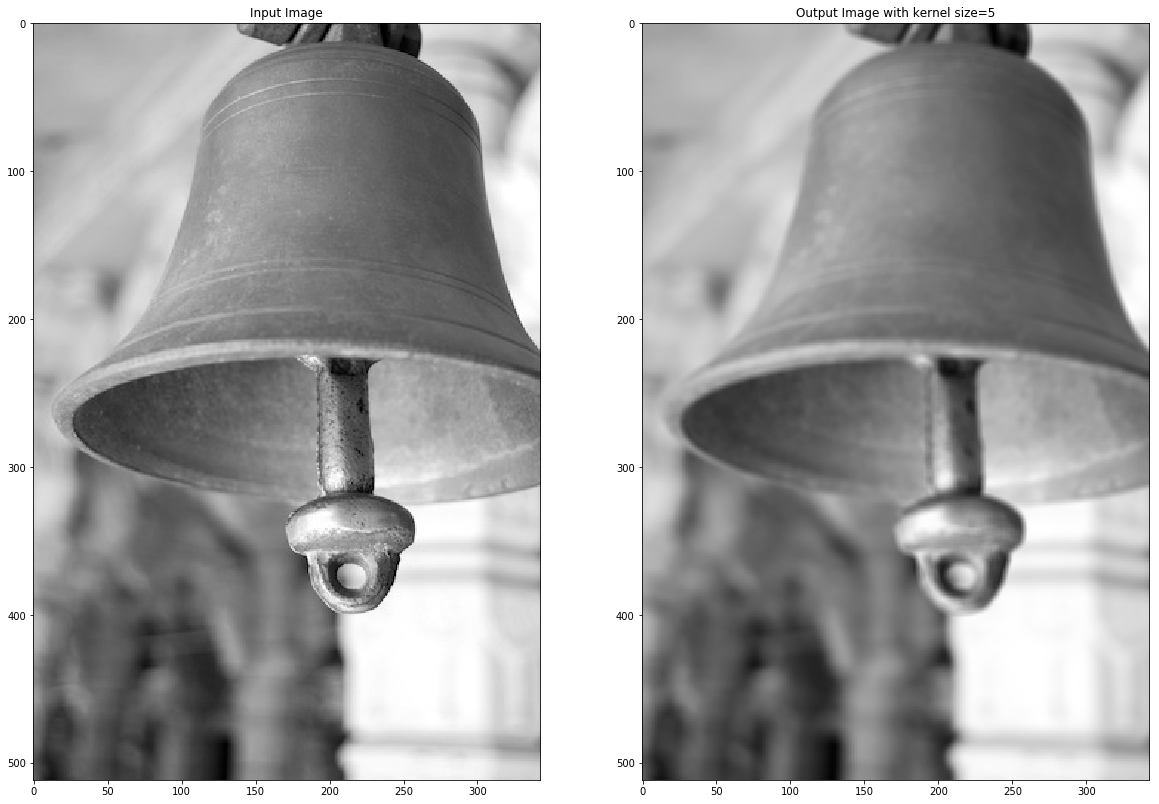

In [73]:
bell_img=cv2.imread('bell.jpg',0)
op1=averaging_filter(bell_img,5) 
plt.subplot(1,2,1)
plt.imshow(bell_img,cmap='gray')
plt.title("Input Image")
plt.subplot(1,2,2)
plt.imshow(op1.astype('uint8'),cmap='gray')
plt.title("Output Image with kernel size=5")
plt.show()

In [75]:
def medianfilter(img,ker):
    size=img.shape
    new_img=img.copy()
    for i in range(1,size[0]-1):
        for j in range(1,size[1]-1):
            temp=img[i-1:i+2,j-1:j+2]
            new_img[i][j]=np.median(temp[:,:])
    
    return new_img

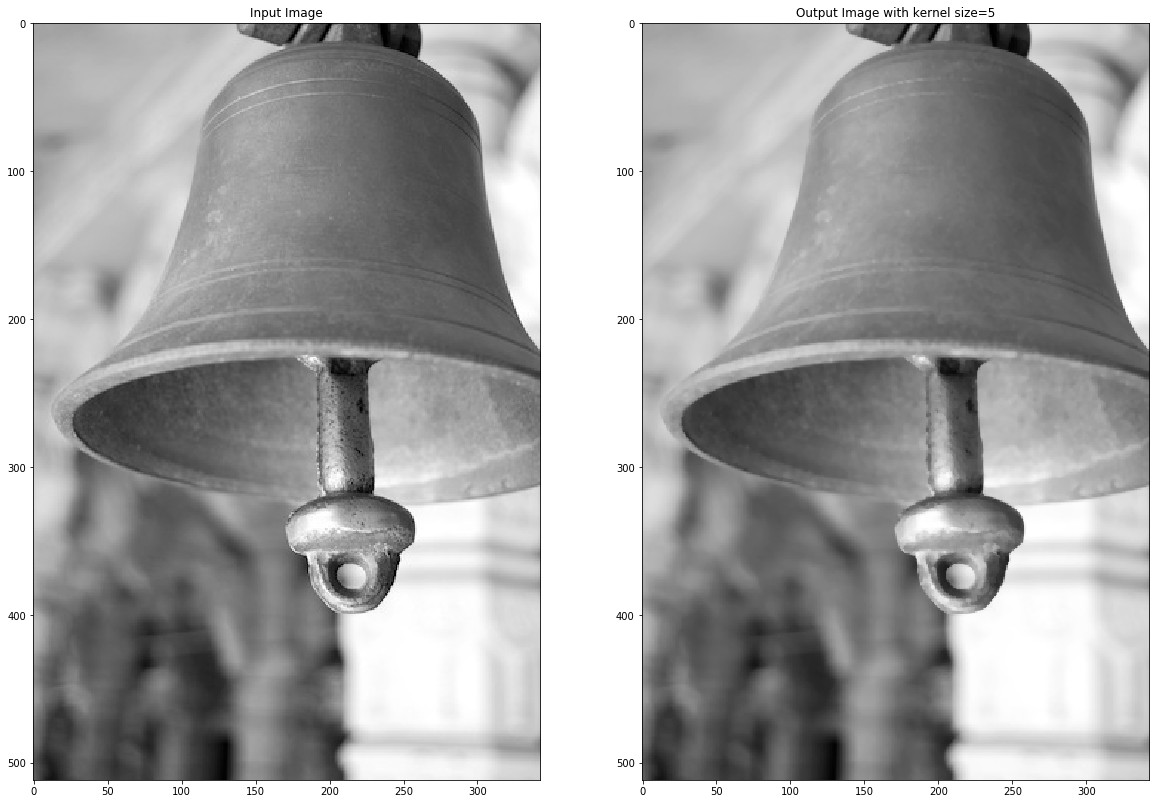

In [76]:
bell_img=cv2.imread('bell.jpg',0)
op1=medianfilter(bell_img,5) 
plt.subplot(1,2,1)
plt.imshow(bell_img,cmap='gray')
plt.title("Input Image")
plt.subplot(1,2,2)
plt.imshow(op1.astype('uint8'),cmap='gray')
plt.title("Output Image with kernel size=5")
plt.show()

In [77]:
def optimized(image, ksize):
    output = np.zeros(image.shape)
    pad_im = np.zeros([image.shape[0]+ksize-1,image.shape[1]+ksize-1])
    pad_im[0:image.shape[0],0:image.shape[1]] = image
    cum_row = np.zeros(pad_im.shape)
    denom = ksize**2
    for i in range(0,image.shape[0]):
        for j in range(0,image.shape[1]):
            if(j==0):
                cum_row[i,j] = pad_im[i,j:j+ksize].sum()
            else:
                cum_row[i,j]+=cum_row[i,j-1]+(pad_im[i,j+ksize-1]-pad_im[i,j-1])
    
    for i in range(0,image.shape[0]):
        for j in range(0,image.shape[1]):
            if(i==0):
                output[i,j] = cum_row[i:i+ksize,j].sum()
            else:
                output[i,j]+=output[i-1,j]+(cum_row[i+ksize-1,j]-cum_row[i-1,j])
    return output/denom

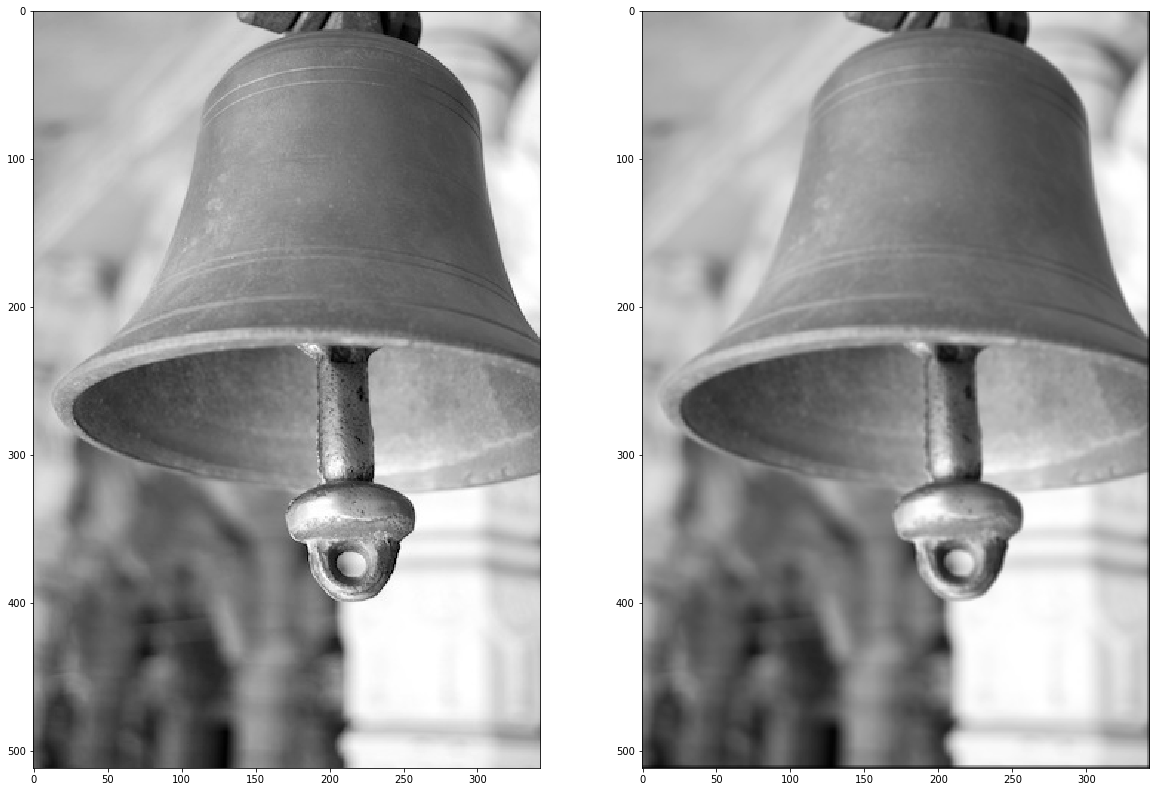

In [78]:
bell_img=cv2.imread('bell.jpg',0)
op1=optimized(bell_img,3)
plt.subplot(1,2,1)
plt.imshow(bell_img,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(op1.astype('uint8'),cmap='gray')
plt.show()

In [79]:
maxk = 30
time_out_filt2D = np.zeros(np.arange(2,maxk).shape)
input_im = bell_img

for i in range(4,maxk):
    ksize = i
    start_filt2D = time()
    out_filt2D = averaging_filter(input_im,ksize)
    time_out_filt2D[i-4] = (time()-start_filt2D)

In [80]:
maxk = 30
time_out_opt = np.zeros(np.arange(2,maxk).shape)
input_im = bell_img

for i in range(4,maxk):
    ksize = i
    start_opt = time()
    out_opt = optimized(input_im, ksize)
    time_out_opt[i-4] = (time()-start_opt)
    

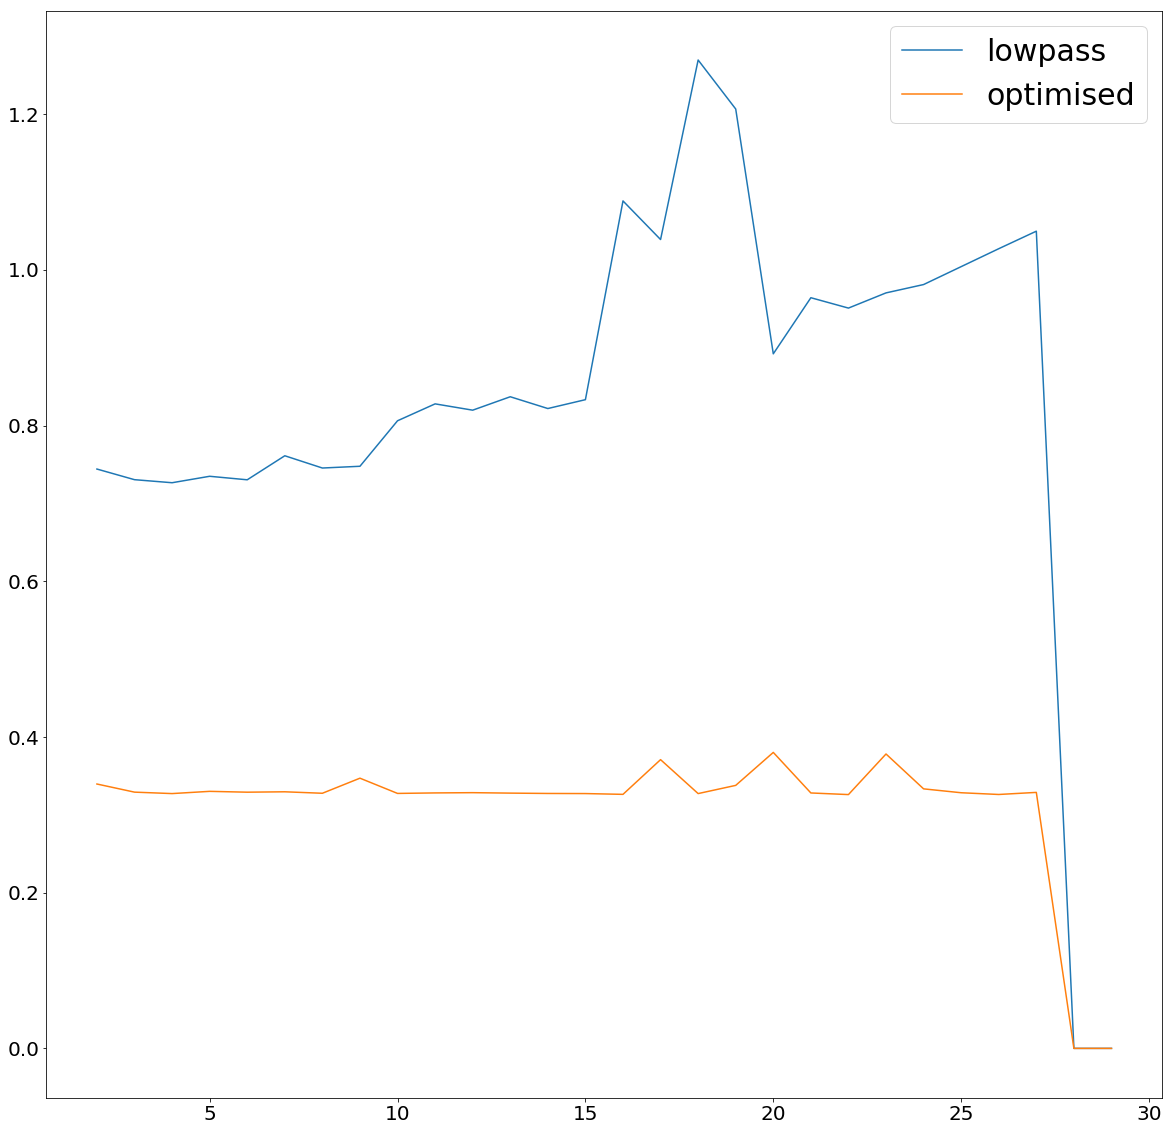

In [81]:
fig = plt.figure(figsize=[20,20])
ax= fig.add_subplot(111)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=50)
ax.plot(range(2,maxk,1),time_out_filt2D,label = 'lowpass')
ax.plot(range(2,maxk,1),time_out_opt, label = 'optimised')
ax.legend(prop={'size': 30})

## Optimized version of median filter

In [1]:
def medopt(image, ksize=3):

    maxInt = np.amax(image)
    output = np.zeros(image.shape)
    pad_im = np.zeros([image.shape[0]+ksize-1,image.shape[1]+ksize-1])
    pad_im[0:image.shape[0],0:image.shape[1]] = image
    ks2 = (ksize**2)
    if (ksize%2 == 0):
        medloc = (ks2/2 + (ks2 - 1)/2)/2
    else:
        medloc = (ks2-1)/2
    medloc+=1

    for i in range(image.shape[0]):
        freq = np.zeros([1,maxInt+1])
        for j in range(image.shape[1]):
            if (j == 0):
                roi = np.ravel(pad_im[i:i+ksize, j:j+ksize]).astype('int64')
                
                for x in range(len(roi)):
                    freq[0,roi[x]]+=1
                freq_cum = np.cumsum(freq)
                
                median = 0
                
                for x in range(maxInt+1):
                    if freq_cum[x]>=medloc:
                        median = x
                        break
                output[i,j] = median
                

            
            else:

                old_roi = np.ravel(pad_im[i:i+ksize,j-1]).astype('int64')
                new_roi = np.ravel(pad_im[i:i+ksize,j+ksize-1]).astype('int64')
                
                for x in range(len(old_roi)):
                    freq[0,old_roi[x]]-=1
                    freq[0,new_roi[x]]+=1
                
                freq[freq<0]=0
                freq[freq>maxInt]=maxInt
                
                freq_cum = np.cumsum(freq)
                

                
                median = 0
                
                for x in range(maxInt+1):
                    if freq_cum[x]>=medloc:
                        median = x
                        break
                
                output[i,j] = median

    return output

In [2]:
def optmedfiltwrap(image, ksize=3):
    output = np.zeros(image.shape)
    if (len(image.shape)==2):
        output = medopt(image,ksize)
    elif (len(image.shape)==3):
        output[:,:,0] = medopt(image[:,:,0],ksize)
        output[:,:,1] = medopt(image[:,:,1],ksize)
        output[:,:,2] = medopt(image[:,:,2],ksize)
        
    return output.astype('uint8')

In [8]:
img=cv2.imread('Degraded.jpg')
output = optmedfiltwrap(img)

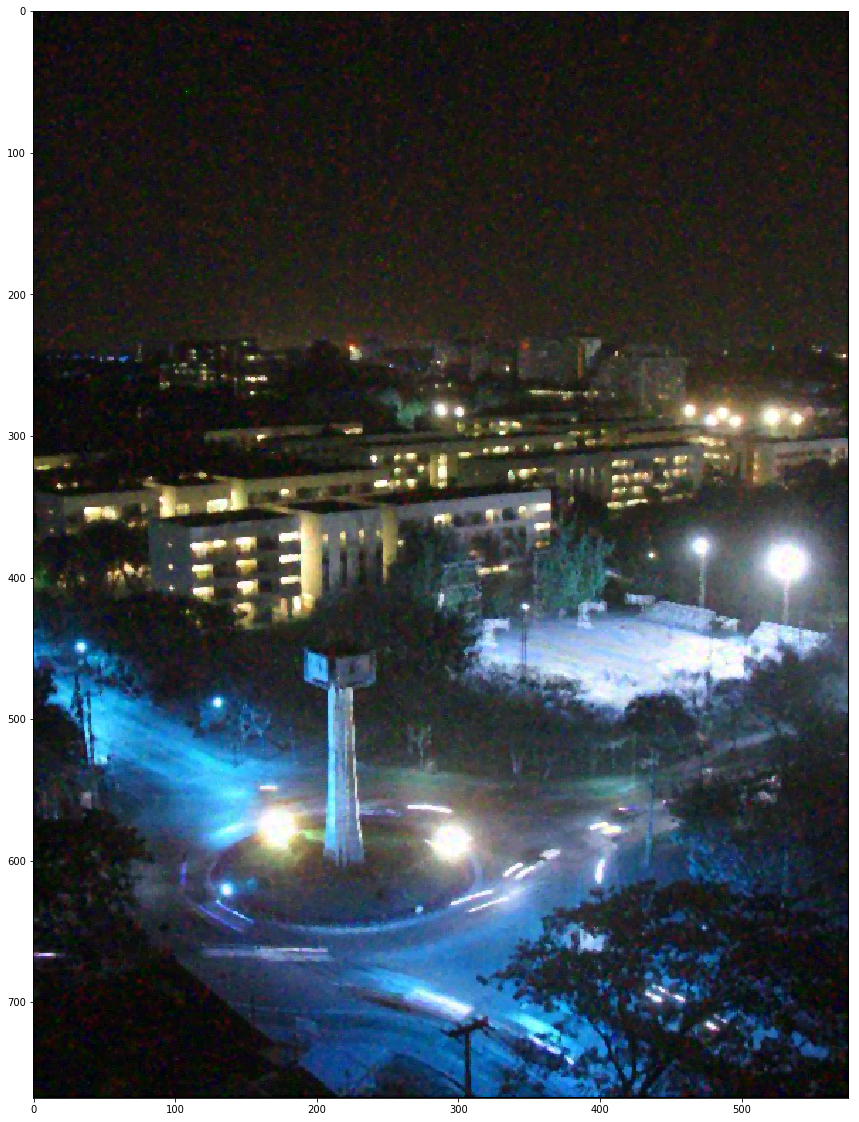

In [9]:
plt.imshow(output)